# rNPV Model for Immunovant's Batoclimab for Hypothetical Addition to Biogen's Immunology Portfolio

## Setup & Probabilistic Distribution Calculations

In [3]:
# SETUP
import numpy as np
import pandas as pd
from scipy.stats import truncnorm, triang, beta, norm
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
SEED_CORE   = 42
SEED_COPULA = 43
np.random.seed(SEED_CORE)

# Global config
N_SIMS        = 10_000
CURRENT_YEAR  = 2025.9   # anchor for discounting
PH3_READOUT_Y = 2026.5   # mid-2026
TAX_RATE      = 0.21

Next we define some typical statistical helper functions including truncated normal sampling, triangular sampling, and beta distributions. We also define a gaussian copula pair function for when we are interested in modeling the dependence between random variables, which in our case may be relevant when comparing variables such as Net price vs Gross-to-Net % (negative correlation), or Years for Peak Uptake vs Peak Uptake % (Negative correlation). This enables us to account for the dependency between variables as both change. 

## Helper Functions for Monte Carlo Simulation

In [6]:
# Helper Functions 

def truncnorm_samples(mean, sd, lower, upper, n):
    """Draw from a truncated normal with [lower, upper] bounds."""
    a, b = (lower - mean) / sd, (upper - mean) / sd
    return truncnorm.rvs(a, b, loc=mean, scale=sd, size=n)

def triangular_samples(left, mode, right, n):
    """Draw from a triangular distribution with min/most-likely/max."""
    c = (mode - left) / (right - left)
    return triang.rvs(c, loc=left, scale=(right - left), size=n)

def beta_from_mean_sd(m, s):
    """Convert target mean & std to Beta(alpha, beta)."""
    v = s**2
    a = m * ((m * (1 - m)) / v - 1)
    b = (1 - m) * ((m * (1 - m)) / v - 1)
    return a, b

# Inverse-CDF (ppf) makers for copula
from scipy.stats import truncnorm as _tn, triang as _tri

def trunc_ppf(mean, sd, lower, upper):
    a, b = (lower - mean)/sd, (upper - mean)/sd
    return _tn(a, b, loc=mean, scale=sd).ppf

def triangular_ppf(left, mode, right):
    c = (mode - left) / (right - left)
    return _tri(c, loc=left, scale=(right - left)).ppf

def gaussian_copula_pair(ppf_x, ppf_y, rho, n, seed=None):
    """Pair of correlated draws using a Gaussian copula."""
    if seed is not None:
        rng = np.random.default_rng(seed)
        z1 = rng.normal(size=n)
        z2 = rho * z1 + np.sqrt(1 - rho**2) * rng.normal(size=n)
    else:
        z1 = np.random.normal(size=n)
        z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal(size=n)
    u1 = norm.cdf(z1); u2 = norm.cdf(z2)
    return ppf_x(u1), ppf_y(u2)

def penetration_path(peak, years_to_peak, total_years):
    """Linear ramp to peak, then flat."""
    years = np.arange(total_years)
    ramp = np.minimum(years / max(1, years_to_peak), 1.0) * peak
    return ramp

Below we simply define the means and standard deviations of all our assumption variables found on slide 7 of the presentation. 

## Base Assumptions from Powerpoint Slide #7

In [9]:
# Base Assumptions (means/ranges) 

# Timing (months)
REG_MEAN, REG_SD, REG_LO, REG_HI   = 12, 3, 6, 24   # Months for Regulatory tasks to complete
PREP_MEAN, PREP_SD, PREP_LO, PREP_HI = 6, 3, 3, 12  # Months for Commercialization tasks to complete

# PoS (means & target SDs for Beta)
POST_P3_MEAN, POST_P3_SD = 0.70, 0.06   # PoS of Phase 3 Study
REG_POS_MEAN, REG_POS_SD = 0.85, 0.04   # PoS of Regulatory tasks

# Market (US+EU treated prevalence & adoption)
PREV_LEFT, PREV_MODE, PREV_RIGHT = 35_000, 47_500, 60_000   # Total annual patient population
PEAK_LEFT, PEAK_MODE, PEAK_RIGHT = 0.45, 0.55, 0.60         # Peak Market uptake (%)
TTP_VALUES, TTP_PROBS = [4, 5, 6], [0.25, 0.50, 0.25]       # Time to peak (Years)

# Pricing (net), GTN noted for completeness
PRICE_MEAN, PRICE_SD, PRICE_LO, PRICE_HI = 200_000, 15_000, 180_000, 220_000   # Annual Net cost of drug
GTN_MEAN,   GTN_SD,   GTN_LO,   GTN_HI   = 0.20, 0.03, 0.15, 0.25              # Gross to Net %
 
# Financials
COGS_MEAN, COGS_SD, COGS_LO, COGS_HI = 0.20, 0.03, 0.15, 0.25   # COGS
SGA_MEAN,  SGA_SD,  SGA_LO,  SGA_HI  = 0.25, 0.04, 0.20, 0.30   # SG&A
WACC_MEAN, WACC_SD, WACC_LO, WACC_HI = 0.10, 0.015, 0.08, 0.12  # WACC

# Exclusivity (years)
EXCL_VALUES, EXCL_PROBS = [9, 10, 11], [0.25, 0.50, 0.25]  # Exclusivity (years)

# Dev costs & timing
PH3_REMAIN_COST  = 45e6     # Cost to finish Phase 3 trial
PH3_COST_YEAR    = 2026.3   # Projected phase 3 end date
REG_LAUNCH_COST  = 25e6     # Projected regulatory costs

In the code below, we sample regulatory review and launch-prep durations from truncated normals within realistic bounds. We then model post-Phase-3 and regulatory PoS with Beta distributions to capture mean and variance (not single points). From there we sample treated prevalence (US+EU) from a triangular (low–mode–high) distribution. Next we use a Gaussian copula to impose correlations—price ↔ GTN (−0.5) and peak penetration ↔ time-to-peak (−0.4), all while preserving each variable’s marginal distribution. We draw COGS, SG&A, and WACC from truncated normals and sample exclusivity as a discrete 9/10/11-year variable. Lastly we convert sampled months to approval and launch years for discounting and revenue timing.

## Calculation of Timing, PoS, Market Uptake and Financial Variable Distributions

In [12]:
# Random Draws (10k)

# Timing - Draws 10k samples for regulatory review and launch-prep durations
# Uses a truncated normal: mean ± sd, but clipped to plausible bounds
reg_months  = truncnorm_samples(REG_MEAN,  REG_SD,  REG_LO,  REG_HI,  N_SIMS)
prep_months = truncnorm_samples(PREP_MEAN, PREP_SD, PREP_LO, PREP_HI, N_SIMS)

# PoS as Beta. We want uncertainty around the success rates (not single-point PoS).
# Beta distributions live on [0,1], perfect for probabilities.
a1, b1 = beta_from_mean_sd(POST_P3_MEAN, POST_P3_SD)
a2, b2 = beta_from_mean_sd(REG_POS_MEAN,  REG_POS_SD)
pos_post_p3 = beta.rvs(a1, b1, size=N_SIMS)
pos_reg     = beta.rvs(a2, b2, size=N_SIMS)

# Treated prevalence (US+EU) is often a low/most-likely/high estimate, thus triangular is natural.
treated_prev = triangular_samples(PREV_LEFT, PREV_MODE, PREV_RIGHT, N_SIMS)

# Correlated price ↔ GTN (−0.5)
# A Gaussian copula makes correlated uniforms (via correlated normals), then maps those uniforms through each variable’s inverse CDF (ppf).
# We get marginal distributions you want and the target correlation.
price_ppf = trunc_ppf(PRICE_MEAN, PRICE_SD, PRICE_LO, PRICE_HI)
gtn_ppf   = trunc_ppf(GTN_MEAN,   GTN_SD,   GTN_LO,   GTN_HI)
price_net, gtn = gaussian_copula_pair(price_ppf, gtn_ppf, rho=-0.5, n=N_SIMS, seed=SEED_COPULA)

# Same copula trick, but one side is triangular (continuous) and the other is a custom discrete inverse CDF returning 4/5/6 years.
# Negative rho makes “bigger peak ↔ faster ramp” more likely.
pen_ppf = triangular_ppf(PEAK_LEFT, PEAK_MODE, PEAK_RIGHT)
def ttp_ppf(u):  # inverse CDF for discrete {4,5,6}
    return np.where(u < 0.25, 4, np.where(u < 0.75, 5, 6)).astype(int)

peak_pen, time_to_peak = gaussian_copula_pair(pen_ppf, ttp_ppf, rho=-0.4, n=N_SIMS, seed=SEED_COPULA+1)

# Financials
# More truncated normals for COGS, SG&A, WACC (reasonable ranges).
# Exclusivity is a small discrete distribution (9/10/11 years) to reflect patent/reg exclusivity uncertainty.
cogs  = truncnorm_samples(COGS_MEAN, COGS_SD, COGS_LO, COGS_HI, N_SIMS)
sga   = truncnorm_samples(SGA_MEAN,  SGA_SD,  SGA_LO,  SGA_HI,  N_SIMS)
wacc  = truncnorm_samples(WACC_MEAN, WACC_SD, WACC_LO, WACC_HI, N_SIMS)
excl  = np.random.choice(EXCL_VALUES, size=N_SIMS, p=EXCL_PROBS)

# Derived dates
# Converts months → calendar years for discounting and revenue timing.
approval_year = PH3_READOUT_Y + reg_months/12.0
launch_year   = approval_year + prep_months/12.0

For wider/narrower uncertainty, adjust SD (normals) or widen triangular bounds. For stronger/weaker dependency, change rho in gaussian_copula_pair. For continuous time-to-peak modeling, replace the discrete ttp_ppf with a truncated normal or triangular. The code below is simply a test to make sure the means, mins and max's of our key variables are within our expectations post-monte carlo simulation. Luckily for us, all of the means align closely to our target value pre-simulation. 

In [14]:
for name, arr in {
    "reg_months": reg_months, "prep_months": prep_months,
    "pos_post_p3": pos_post_p3, "pos_reg": pos_reg,
    "treated_prev": treated_prev, "price_net": price_net,
    "peak_pen": peak_pen, "time_to_peak": time_to_peak,
    "cogs": cogs, "sga": sga, "wacc": wacc, "excl": excl
}.items():
    print(f'{name}, Mean: {np.mean(arr):.2f}, Min: {np.min(arr):.2f}, Max: {np.max(arr):.2f}')

# Correlation checks:
corr_price_gtn = np.corrcoef(price_net, gtn)[0,1]
corr_peak_ttp  = np.corrcoef(peak_pen, time_to_peak)[0,1]
print("Correlation between Drug Price and Gross-to-Net =", round(corr_price_gtn,3))
print("Correlation between Peak Penetration % and Time to Peak =", round(corr_peak_ttp,3))

reg_months, Mean: 12.11, Min: 6.00, Max: 22.27
prep_months, Mean: 6.72, Min: 3.00, Max: 12.00
pos_post_p3, Mean: 0.70, Min: 0.46, Max: 0.89
pos_reg, Mean: 0.85, Min: 0.67, Max: 0.96
treated_prev, Mean: 47499.59, Min: 35092.75, Max: 59792.76
price_net, Mean: 199885.95, Min: 180023.86, Max: 219986.11
peak_pen, Mean: 0.53, Min: 0.45, Max: 0.60
time_to_peak, Mean: 5.00, Min: 4.00, Max: 6.00
cogs, Mean: 0.20, Min: 0.15, Max: 0.25
sga, Mean: 0.25, Min: 0.20, Max: 0.30
wacc, Mean: 0.10, Min: 0.08, Max: 0.12
excl, Mean: 10.00, Min: 9.00, Max: 11.00
Correlation between Drug Price and Gross-to-Net = -0.478
Correlation between Peak Penetration % and Time to Peak = -0.372


Everything above looks in line with our target means, and as we expected, we observe moderate negative correlations between Drug Price and Gross-to-Net, as well as Peak Penetration % and Time to Peak.

## Monte Carlo rNPV Model

In [17]:
# rNPV Model

# Safety: check required objects exist 
_required = [
    "N_SIMS","CURRENT_YEAR","PH3_READOUT_Y","TAX_RATE",
    "reg_months","prep_months","pos_post_p3","pos_reg","treated_prev",
    "price_net","peak_pen","time_to_peak","cogs","sga","wacc","excl",
    "PH3_REMAIN_COST","PH3_COST_YEAR","REG_LAUNCH_COST","penetration_path"
]
_missing = [v for v in _required if v not in globals()]
if _missing:
    raise RuntimeError(f"Missing from Section 1: {', '.join(_missing)}")

# Derived dates from sampled durations 
approval_year = PH3_READOUT_Y + reg_months/12.0
launch_year   = approval_year + prep_months/12.0

# Monte Carlo rNPV per simulation 
rnpv = np.zeros(N_SIMS, dtype=float)
rows = []

for i in range(N_SIMS):
    appr    = approval_year[i]
    launch  = launch_year[i]
    ex_years= int(excl[i])

    # commercial years within exclusivity window
    start_y = int(np.floor(launch))
    end_y   = int(np.floor(launch + ex_years))
    years   = np.arange(start_y, end_y + 1)
    T       = len(years)
    if T <= 0:
        # edge-case guard
        rnpv[i] = -PH3_REMAIN_COST
        continue

    # adoption → revenue → free cash flow
    pen_path     = penetration_path(peak=peak_pen[i], years_to_peak=int(time_to_peak[i]), total_years=T)
    patients_t   = treated_prev[i] * pen_path
    revenue_t    = patients_t * price_net[i]                  # net price already
    gross_margin = max(0.0, 1.0 - cogs[i] - sga[i])           # safeguard
    fcf_t        = revenue_t * gross_margin * (1.0 - TAX_RATE)

    # probability weighting & discounting
    cum_pos      = float(pos_post_p3[i] * pos_reg[i])         # post-P3 × regulatory
    weighted_cf  = fcf_t * cum_pos
    disc         = (1.0 + wacc[i]) ** (years - CURRENT_YEAR)
    pv_sales     = np.sum(weighted_cf / disc)

    # remaining dev costs (PV):
    # - Phase 3 remaining is committed (no PoS multiplier)
    pv_ph3 = PH3_REMAIN_COST / ((1.0 + wacc[i]) ** (PH3_COST_YEAR - CURRENT_YEAR))
    # - Regulatory/launch spend occurs only if Phase 3 success
    pv_reg = (REG_LAUNCH_COST * pos_post_p3[i]) / ((1.0 + wacc[i]) ** (float(appr + 0.25) - CURRENT_YEAR))

    rnpv[i] = pv_sales - pv_ph3 - pv_reg

    # store drivers for diagnostics
    rows.append({
        "approval_year": appr,
        "launch_year": launch,
        "cum_pos": cum_pos,
        "patients_total": treated_prev[i],
        "peak_pen": peak_pen[i],
        "time_to_peak": time_to_peak[i],
        "price_net": price_net[i],
        "cogs": cogs[i],
        "sga": sga[i],
        "wacc": wacc[i],
        "excl_years": ex_years,
        "rNPV": rnpv[i],
    })

sim_df = pd.DataFrame(rows)

In the section above, the model converts each simulation’s sampled parameters into a full cash-flow path to compute the risk-adjusted net present value (rNPV). Each run begins by translating regulatory and launch-prep durations into approval and launch years, then defines a commercial window equal to the exclusivity period. For each year in that window, the model simulates market adoption, multiplies the treated population by the sampled drug price, and calculates free cash flow after subtracting manufacturing (COGS), selling (SG&A), and taxes. The price variable used here is already net of the 20% gross-to-net adjustment, consistent with specialty-biologic benchmarks; therefore, no further discounting is applied inside the simulation. Also, the market penetration rate is assumed to be linear until the peak sales year, and then flate thereafter. These free cash flows are then weighted by the cumulative probability of technical success (post-Phase-3 × regulatory) and discounted back to 2025 using the simulation-specific WACC. Finally, the model subtracts the present value of the remaining Phase-3 and regulatory/launch costs, treating the Phase-3 spend as committed and the regulatory spend as contingent on Phase-3 success—to yield one rNPV estimate per run. Repeating this process 10,000 times produces the full Monte Carlo distribution used for the fair-value band analysis.

## Deterministic rNPV Model for Comparison vs Monte Carlo rNPV Distribution

In [20]:
# Deterministic base-case using means for comparison
means = {
    "reg_m": reg_months.mean(),
    "prep_m": prep_months.mean(),
    "post_p3": pos_post_p3.mean(),
    "reg": pos_reg.mean(),
    "prev": treated_prev.mean(),
    "peak": peak_pen.mean(),
    "ttp": int(round(time_to_peak.mean())),
    "price": price_net.mean(),
    "cogs": cogs.mean(),
    "sga": sga.mean(),
    "wacc": wacc.mean(),
    "excl": int(round(excl.mean()))
}
appr_bc   = PH3_READOUT_Y + means["reg_m"]/12.0
launch_bc = appr_bc + means["prep_m"]/12.0
years_bc  = np.arange(int(np.floor(launch_bc)), int(np.floor(launch_bc + means["excl"])) + 1)
pen_bc    = penetration_path(means["peak"], means["ttp"], len(years_bc))
rev_bc    = (means["prev"] * pen_bc * means["price"])
margin_bc = max(0.0, 1.0 - means["cogs"] - means["sga"])
fcf_bc    = rev_bc * margin_bc * (1.0 - TAX_RATE)
cum_pos_bc= means["post_p3"] * means["reg"]
disc_bc   = (1.0 + means["wacc"]) ** (years_bc - CURRENT_YEAR)
pv_sales_bc = np.sum((fcf_bc * cum_pos_bc) / disc_bc)
pv_ph3_bc   = PH3_REMAIN_COST / ((1.0 + means["wacc"]) ** (PH3_COST_YEAR - CURRENT_YEAR))
pv_reg_bc   = (REG_LAUNCH_COST * means["post_p3"]) / ((1.0 + means["wacc"]) ** (float(appr_bc + 0.25) - CURRENT_YEAR))
base_rnpv   = pv_sales_bc - pv_ph3_bc - pv_reg_bc

This block above computes a deterministic base case by replacing all sampled inputs with their means and running the same rNPV pipeline. It derives approval/launch timing, builds the mean adoption curve, calculates free cash flows, applies the mean cumulative PoS, and discounts with the mean WACC. After subtracting PV of remaining Phase-3 and reg/launch costs, it yields a single base-case rNPV to be used as a benchmark to compare with the Monte Carlo median and intervals.

In [22]:
# Fair-value band & decision stats 
p10, p25, p50, p75, p90 = np.percentile(rnpv, [10, 25, 50, 75, 90])
prob_pos = float((rnpv > 0).mean())
es25     = float(rnpv[rnpv <= p25].mean())   # expected shortfall (bottom quartile)

summary = pd.DataFrame({
    "Metric": [
        "Base-case rNPV (means)",
        "P50 rNPV (median)",
        "P25 rNPV",
        "P75 rNPV",
        "P10 rNPV",
        "P90 rNPV",
        "Prob(rNPV > 0)",
        "ES_25 (mean of bottom quartile)"
    ],
    "Value (USD)": [base_rnpv, p50, p25, p75, p10, p90, prob_pos, es25]
})
summary

,Metric,Value (USD)
0,Base-case rNPV (means),4.739596e+09
1,P50 rNPV (median),4.847488e+09
2,P25 rNPV,4.148453e+09
3,P75 rNPV,5.634646e+09
4,P10 rNPV,3.617069e+09
5,P90 rNPV,6.455903e+09
6,Prob(rNPV > 0),1.000000e+00
7,ES_25 (mean of bottom quartile),3.648235e+09


The median rNPV (P50) for Batoclimab in Myasthenia Gravis is approximately 4.85B, which aligns closely with the deterministic base-case rNPV ($4.74B), indicating the model is well-calibrated and that mean assumptions sit near the center of the simulated outcome distribution.

The P25–P75 “fair-value band” spans roughly 4.15B to 5.63B, capturing the interquartile range of plausible valuations under moderate uncertainty in price, adoption, and cost assumptions. This ±15–20 % swing reflects a balanced risk-return profile typical of a Phase 3 biologic with de-risked mechanism and known class precedents.

At the P10 and P90 percentiles, the distribution’s tails range from 3.6B to 6.45B, defining the 80% confidence window for valuation outcomes. The expected shortfall (ES25), the mean of the bottom quartile, is $3.65B, providing a stress-test view of downside exposure if multiple adverse assumptions align (slow adoption, lower price, or extended review).

Finally, Prob(rNPV > 0) = 1.00, confirming that under no realistic combination of assumptions does the model produce a negative rNPV. This strongly supports the investment case: Batoclimab’s downside risk is limited to reduced upside magnitude, not outright value destruction.

## Presentation Visuals

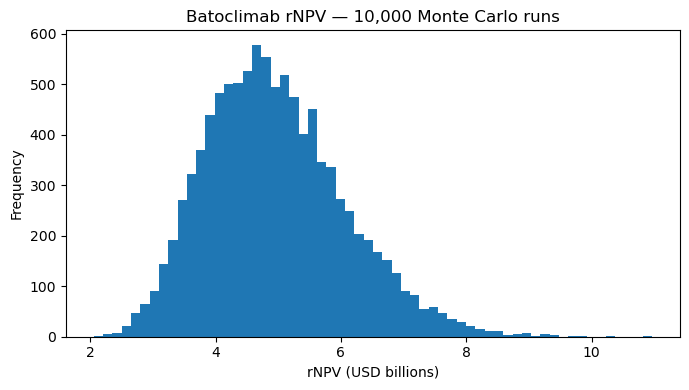

In [25]:
# Histogram of rNPV
plt.figure(figsize=(7,4))
plt.hist(rnpv/1e9, bins=60)
plt.xlabel("rNPV (USD billions)")
plt.ylabel("Frequency")
plt.title("Batoclimab rNPV — 10,000 Monte Carlo runs")
plt.tight_layout()
plt.show()

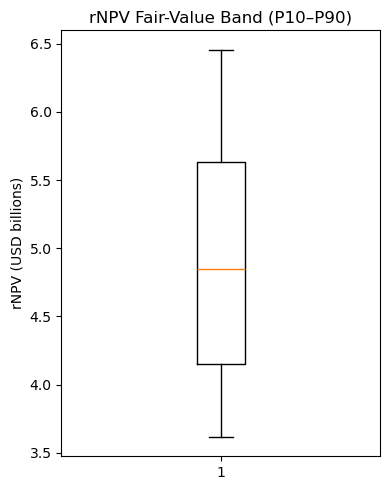

In [26]:
# Fair-value band
plt.figure(figsize=(4,5))
plt.boxplot(rnpv/1e9, vert=True, whis=[10,90], showfliers=False)
plt.ylabel("rNPV (USD billions)")
plt.title("rNPV Fair-Value Band (P10–P90)")
plt.tight_layout()
plt.show()

Below is a visual of the Monte Carlo simulation of Batoclimab’s risk-adjusted NPV (10,000 runs) showing a median value of approximately 4.8 billion and a fair-value range (P25-P75) of 4.1-5.6 billion. 

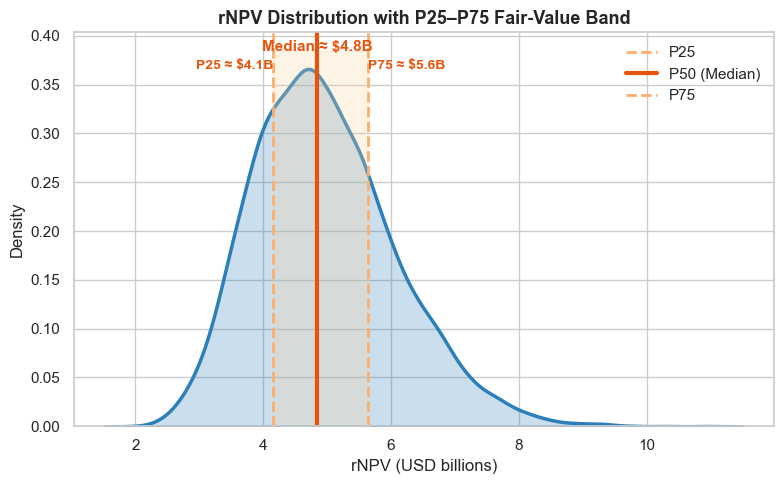

In [28]:
# Style setup
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,5))

# KDE curve 
sns.kdeplot(rnpv/1e9, fill=True, color="#2c7fb8", alpha=0.25, linewidth=2.5)

# Quartile markers 
plt.axvline(p25/1e9, color="#fdae6b", linestyle="--", lw=2, label="P25")
plt.axvline(p50/1e9, color="#e6550d", linestyle="-",  lw=3, label="P50 (Median)")
plt.axvline(p75/1e9, color="#fdae6b", linestyle="--", lw=2, label="P75")

# Shaded fair-value band 
plt.fill_betweenx([0, plt.gca().get_ylim()[1]], p25/1e9, p75/1e9, color="#fdd49e", alpha=0.25)

#  Annotations 
y_pos = plt.gca().get_ylim()[1] * 0.9  # anchor text at 90% of y-axis height
plt.text(p25/1e9, y_pos, "P25 ≈ $4.1B", color="#e6550d", ha="right", va="bottom", fontsize=10, fontweight="semibold")
plt.text(p50/1e9, y_pos * 1.05, "Median ≈ $4.8B", color="#e6550d", ha="center", va="bottom", fontsize=11, fontweight="bold")
plt.text(p75/1e9, y_pos, "P75 ≈ $5.6B", color="#e6550d", ha="left", va="bottom", fontsize=10, fontweight="semibold")

# Formatting 
plt.title("rNPV Distribution with P25–P75 Fair-Value Band", fontsize=13, weight="bold")
plt.xlabel("rNPV (USD billions)")
plt.ylabel("Density")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

The next analyses identify which inputs most strongly influence Batoclimab’s modeled value. The tornado chart quantifies the impact on rNPV between the 10th and 90th percentile of each input variable, showing which assumptions drive the greatest swing in valuation. The Spearman rank correlation provides a complementary view of direction and monotonicity (whether higher or lower values of each driver tend to increase or decrease rNPV). Together, these methods confirm that market-facing parameters (treated population, penetration, and pricing) dominate valuation uncertainty, while scientific and cost-side variables have smaller effects due to the asset’s late-stage, de-risked profile.

In [30]:
# Choose variables to assess
VARS = {
    "Peak Market Penetration (%)": "peak_pen",
    "Net Annual Drug price (USD)": "price_net",
    "WACC (%)": "wacc",
    "Annual Patient Population": "patients_total",
    "Cumulative PoS (post-P3 × reg)": "cum_pos",   # <- was pos_post_p3
    "Time to Sales Peak (yrs)": "time_to_peak",
    "COGS (%)": "cogs",
    "SG&A (%)": "sga",
}

# Tornado function that calculated delta rNPV between 90th and 10th percentiles fo variable ranges
def tornado_p90_p10(df, var, y="rNPV"):
    lo = df[var].quantile(0.10)
    hi = df[var].quantile(0.90)
    med_lo = df.loc[df[var] <= lo, y].median()
    med_hi = df.loc[df[var] >= hi, y].median()
    delta = (med_hi - med_lo) / 1e9  # $ billions
    return float(delta)

rows = []
for label, col in VARS.items():
    rows.append({"Driver": label, "Δ rNPV (P90−P10), $B": tornado_p90_p10(sim_df, col)})

tornado_df = pd.DataFrame(rows).assign(abs_delta=lambda d: d["Δ rNPV (P90−P10), $B"].abs())
tornado_df = tornado_df.sort_values("abs_delta", ascending=True)

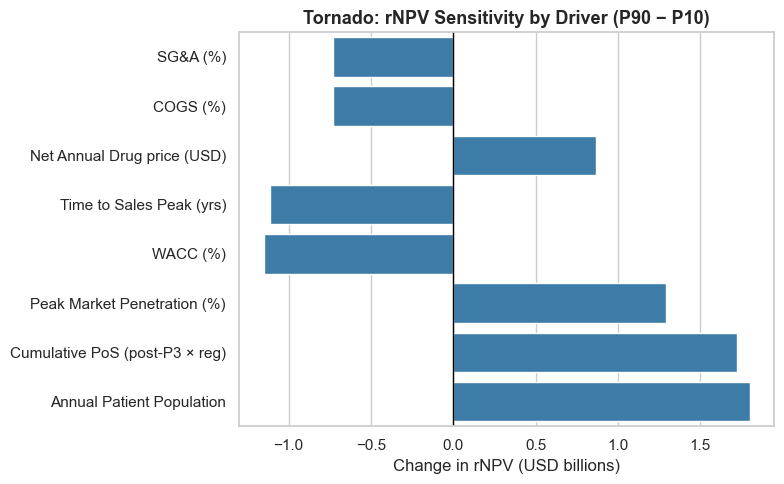

In [31]:
# Construct the tornado plot
plt.figure(figsize=(8,5))
sns.barplot(
    data=tornado_df,
    x="Δ rNPV (P90−P10), $B",
    y="Driver",
    color="#2c7fb8",
)
plt.axvline(0, color="black", lw=1)
plt.title("Tornado: rNPV Sensitivity by Driver (P90 − P10)", fontsize=13, weight="bold")
plt.xlabel("Change in rNPV (USD billions)")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [32]:
# Calculate the correlation between individual variables and rNPV
from scipy.stats import spearmanr

corr_rows = []
for label, col in VARS.items():
    rho, p = spearmanr(sim_df[col], sim_df["rNPV"])
    corr_rows.append({"Driver": label, "Spearman ρ": rho})
pd.DataFrame(corr_rows).sort_values("Spearman ρ", key=np.abs, ascending=False)

,Driver,Spearman ρ
3,Annual Patient Population,0.486632
4,Cumulative PoS (post-P3 × reg),0.439902
5,Time to Sales Peak (yrs),-0.346191
0,Peak Market Penetration (%),0.346131
2,WACC (%),-0.312613
1,Net Annual Drug price (USD),0.240645
7,SG&A (%),-0.208384
6,COGS (%),-0.188942
